# Segment the adult dataset using GOWER similarity and DBScan Clustering

In [132]:
%matplotlib inline

import pandas as pd
import pylab
import numpy as np
import seaborn as sns
from feature_engine.encoding import RareLabelEncoder
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import gower
from sklearn.model_selection import GridSearchCV

In [2]:
#sns.set_theme(style="darkgrid")

# Import Data
the dataset is available here: https://archive.ics.uci.edu/ml/datasets/adult

In [3]:

try:
        # load the local dataset 
        df = pd.read_csv('../data/adult_dataset.csv')
except:
        # load the dataset from uci
        features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
                "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
                "Hours per week", "Country", "Target"] 

        # Change these to local file if available
        train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
        test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

        # This will download 3.8M
        original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                                engine='python', na_values="?")
        # This will download 1.9M
        original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                                engine='python', na_values="?", skiprows=1)

        # combine both datasets
        df = pd.concat([original_train, original_test], axis=0)
        # save the data locally
        df.to_csv('../data/adult_dataset.csv', index=False)                            

In [4]:
df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Relabel taget colum since there is no target in unsupervised learning
df.rename(columns={"Target": "Income"}, inplace=True)

In [6]:
#Correct the Income column typo
df['Income'] = df['Income'].apply(lambda x: x.replace('.', ''))

# Train-Test Split the Data

In [7]:
df.shape

(48842, 15)

In [8]:
# way too much data for training; let´s split the data
X_train, X_test = train_test_split(df, test_size=0.75, random_state=123)

In [9]:
X_train.shape

(12210, 15)

In [10]:
X_test.shape

(36632, 15)

In [11]:
X_train.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
26763,63,Private,124242,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,40,United-States,<=50K
32676,26,Private,206721,HS-grad,9,Never-married,Handlers-cleaners,Unmarried,White,Male,0,0,40,United-States,<=50K
27426,18,NaN,348588,12th,8,Never-married,NaN,Own-child,Black,Male,0,0,25,United-States,<=50K
29074,26,Private,68991,HS-grad,9,Never-married,Other-service,Unmarried,Black,Male,0,0,40,United-States,<=50K
30398,61,Private,103575,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,37,United-States,<=50K


# Exploratory Data Analysis

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12210 entries, 26763 to 15725
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             12210 non-null  int64 
 1   Workclass       11485 non-null  object
 2   fnlwgt          12210 non-null  int64 
 3   Education       12210 non-null  object
 4   Education-Num   12210 non-null  int64 
 5   Martial Status  12210 non-null  object
 6   Occupation      11484 non-null  object
 7   Relationship    12210 non-null  object
 8   Race            12210 non-null  object
 9   Sex             12210 non-null  object
 10  Capital Gain    12210 non-null  int64 
 11  Capital Loss    12210 non-null  int64 
 12  Hours per week  12210 non-null  int64 
 13  Country         12001 non-null  object
 14  Income          12210 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.5+ MB


In [13]:
X_train.isna().sum()

Age                 0
Workclass         725
fnlwgt              0
Education           0
Education-Num       0
Martial Status      0
Occupation        726
Relationship        0
Race                0
Sex                 0
Capital Gain        0
Capital Loss        0
Hours per week      0
Country           209
Income              0
dtype: int64

## Impute Missing Values

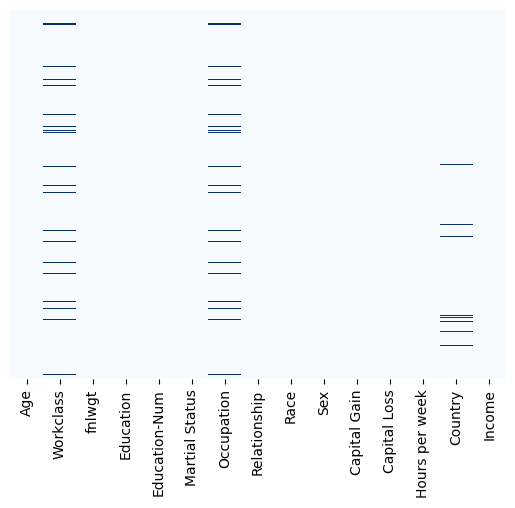

In [14]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [15]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [16]:
numeric_columns = X_train.select_dtypes(include=numerics).columns.to_list()
numeric_columns

['Age',
 'fnlwgt',
 'Education-Num',
 'Capital Gain',
 'Capital Loss',
 'Hours per week']

In [17]:
categorical_columns = X_train.select_dtypes(exclude=numerics).columns.to_list()
categorical_columns

['Workclass',
 'Education',
 'Martial Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country',
 'Income']

In [18]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)
X_train_numeric.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
26763,63.0,124242.0,9.0,0.0,0.0,40.0
32676,26.0,206721.0,9.0,0.0,0.0,40.0
27426,18.0,348588.0,8.0,0.0,0.0,25.0
29074,26.0,68991.0,9.0,0.0,0.0,40.0
30398,61.0,103575.0,9.0,0.0,0.0,37.0


In [19]:
# Impute missing categorical values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
26763,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K
32676,Private,HS-grad,Never-married,Handlers-cleaners,Unmarried,White,Male,United-States,<=50K
27426,Private,12th,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K
29074,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K
30398,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K


In [20]:
# Save imputers both numerical and categorical
from joblib import dump
dump(numeric_imputer, '../artifacts/numeric_imputer.joblib')
dump(categorical_imputer, '../artifacts/categorical_imputer.joblib')


['../artifacts/categorical_imputer.joblib']

In [21]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
26763,63.0,124242.0,9.0,0.0,0.0,40.0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K
32676,26.0,206721.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Handlers-cleaners,Unmarried,White,Male,United-States,<=50K
27426,18.0,348588.0,8.0,0.0,0.0,25.0,Private,12th,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K
29074,26.0,68991.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K
30398,61.0,103575.0,9.0,0.0,0.0,37.0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K


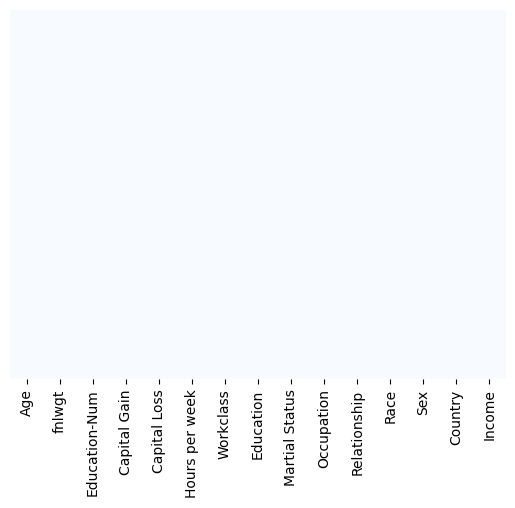

In [22]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Visualize Categorical Features

In [23]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category Workclass: 
Private             9136
Self-emp-not-inc     971
Local-gov            839
State-gov            500
Self-emp-inc         435
Federal-gov          324
Without-pay            4
Never-worked           1
Name: Workclass, dtype: int64
Value counts in category Education: 
HS-grad         3923
Some-college    2688
Bachelors       2026
Masters          670
Assoc-voc        527
11th             461
Assoc-acdm       411
10th             337
7th-8th          230
9th              202
Prof-school      199
12th             166
Doctorate        153
5th-6th          123
1st-4th           73
Preschool         21
Name: Education, dtype: int64
Value counts in category Martial Status: 
Married-civ-spouse       5586
Never-married            4032
Divorced                 1645
Separated                 389
Widowed                   372
Married-spouse-absent     172
Married-AF-spouse          14
Name: Martial Status, dtype: int64
Value counts in category Occupation: 
Exec-

## Encode Rare Labels

In [24]:
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=10)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique categories for variable Workclass is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique categories for variable Martial Status is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique categories for variable Relationship is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
c:\Users\Sebas\anaconda3\envs\aws_sagemaker\lib\site-packages\feature_engine\encoding\rare_label.py:199: UserWarning: The number of unique c

,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
26763,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K
32676,Private,HS-grad,Never-married,Rare,Unmarried,White,Male,United-States,<=50K
27426,Private,Rare,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K
29074,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K
30398,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K


In [25]:
# Save rare label encoder
from joblib import dump
dump(rare_encoder, '../artifacts/rare_encoder.joblib')

['../artifacts/rare_encoder.joblib']

## Visualize Numerical Features

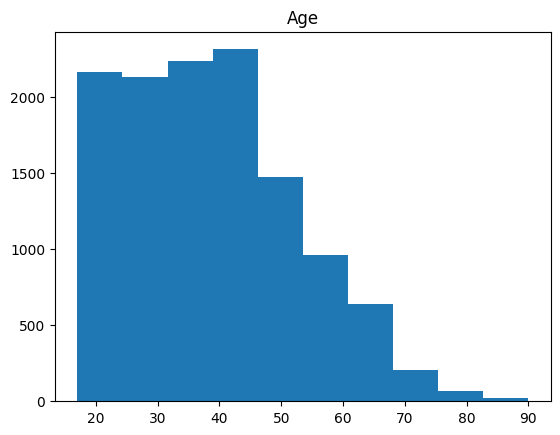

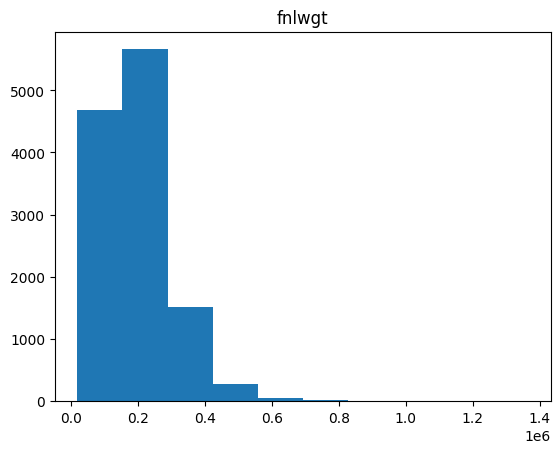

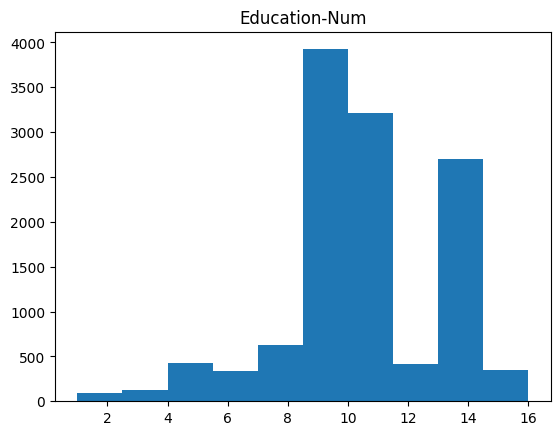

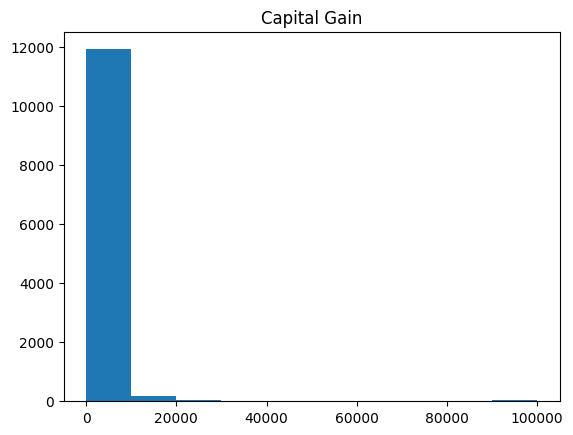

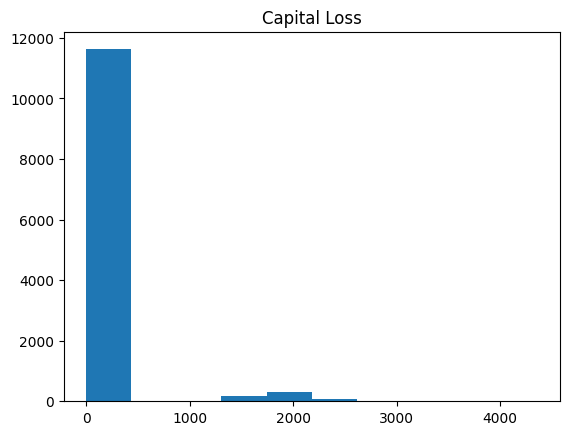

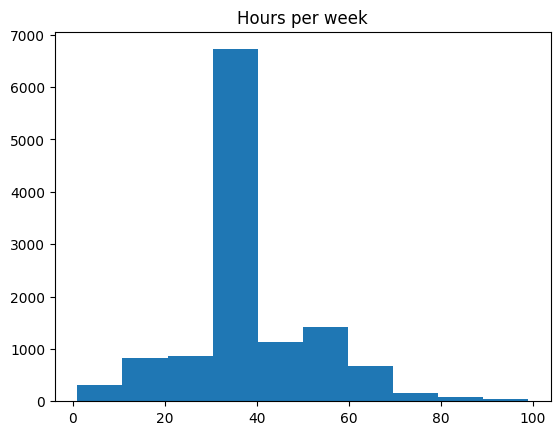

In [26]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [27]:
from feature_engine.outliers import Winsorizer

In [28]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [29]:
# fit the capper
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
26763,63.0,124242.0,9.0,0.0,0.0,40.0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K
32676,26.0,206721.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Rare,Unmarried,White,Male,United-States,<=50K
27426,18.0,348588.0,8.0,0.0,0.0,25.0,Private,Rare,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K
29074,26.0,68991.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K
30398,61.0,103575.0,9.0,0.0,0.0,37.0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K


In [30]:
# Save capper 
from joblib import dump
dump(capper, '../artifacts/capper.joblib')

['../artifacts/capper.joblib']

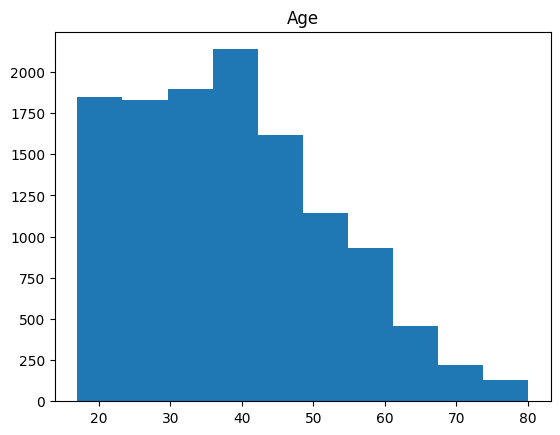

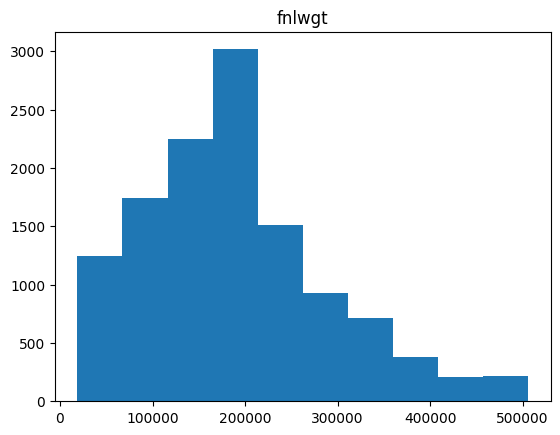

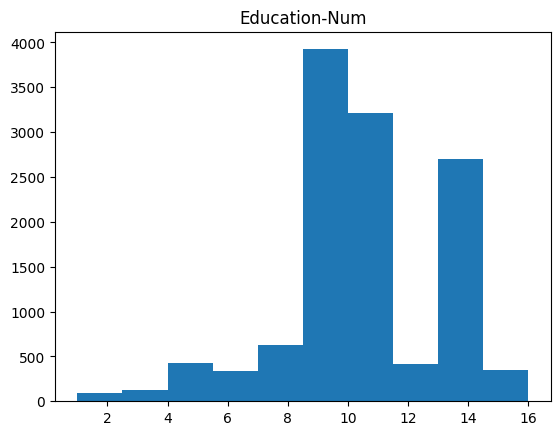

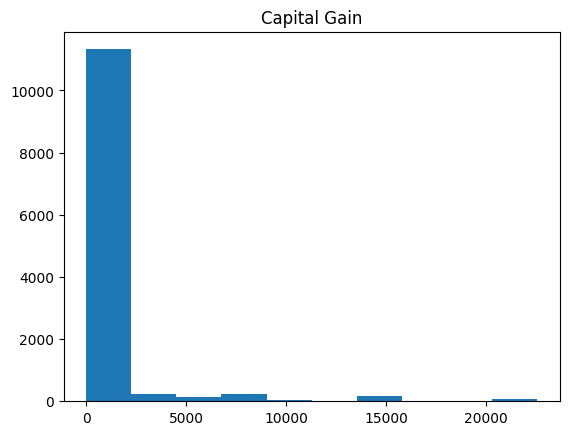

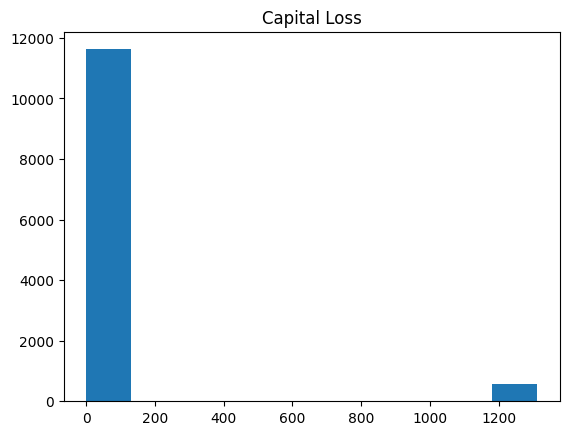

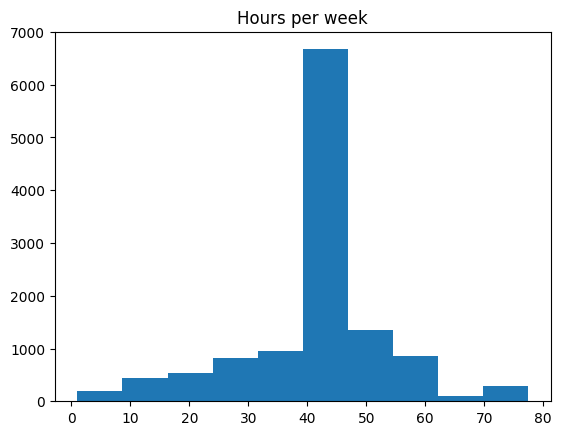

In [31]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

# Calculate Customer Similarity using Gower´s Distance

In [32]:
%%time
distance_matrix = gower.gower_matrix(X_train)

CPU times: total: 3min 8s
Wall time: 3min 10s


In [33]:
distance_matrix.shape

(12210, 12210)

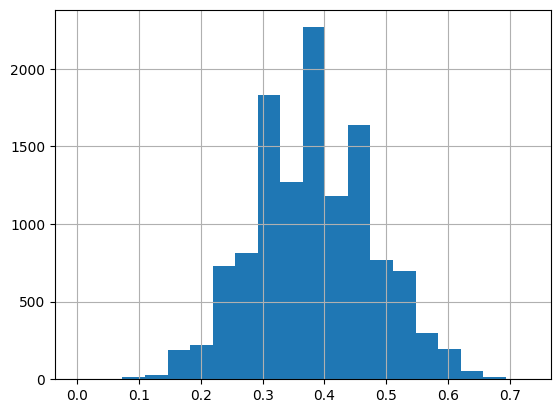

In [34]:
customer = 3
plt.hist(distance_matrix[:,customer], bins=20)
plt.grid()
plt.show()

In [35]:
# let´s choose a cut-off gower´s distance of e.g. 0.2
gower_cutoff = 0.2  

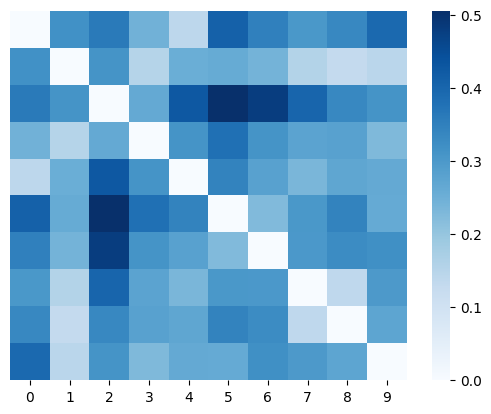

In [36]:
# plot the similarity matrix as heatmap
sns.heatmap(
    distance_matrix[:10,:10], 
    yticklabels = False, 
    cbar = True, 
    cmap="Blues")
plt.show()

In [37]:
# find the top-n customers similar to a particular customer
customer=100
top_n = gower.gower_topn(
    X_train.iloc[customer:customer+1,:], 
    X_train.iloc[:,], 
    n = 5)
top_n

{'index': array([ 100, 1626, 3629, 6448, 4014], dtype=int64),
 'values': array([0.        , 0.02376317, 0.0348122 , 0.03522712, 0.0356093 ],
       dtype=float32)}

In [38]:
top_n['index']

array([ 100, 1626, 3629, 6448, 4014], dtype=int64)

In [39]:
X_train.iloc[top_n['index'],:]

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
1819,43.0,206139.0,13.0,0.0,0.0,50.0,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K
24170,41.0,47902.0,13.0,0.0,0.0,50.0,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K
37147,32.0,113129.0,13.0,0.0,0.0,38.0,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K
34281,42.0,392167.0,13.0,0.0,0.0,40.0,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K
4808,49.0,55938.0,13.0,0.0,0.0,40.0,State-gov,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K


# DBScan Clustering

In [40]:
from sklearn.cluster import DBSCAN

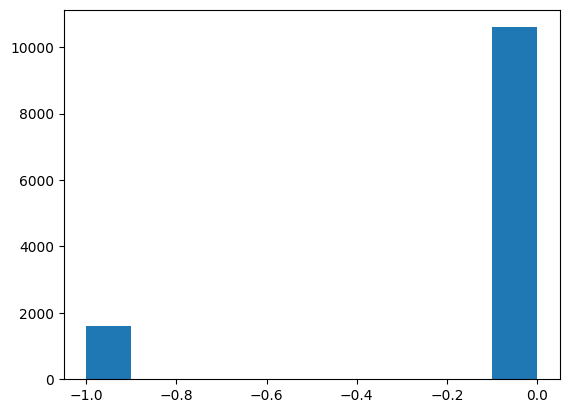

CPU times: total: 1.61 s
Wall time: 1.61 s


In [41]:
%%time
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.1, 
                        min_samples=25, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
#plt.ylim(0,1000)
plt.show()

In [42]:
# Compute Cluster Quality using Silhouette Score
from sklearn.metrics import silhouette_score

silhouette_score(X=distance_matrix, labels=dbscan_cluster.labels_, metric="precomputed")

0.1694581

In [43]:
%%time
# lets try different hyperparameters and count the cluster numbers; we dont want like 100 cluster but we do want maybe more than 2 clusters

results_list = []
eps_range = np.arange(.05, 0.25, .025)
min_sample_range = np.arange(5, 50, 5)

for eps in eps_range:
    for min_samples in min_sample_range:

        # Configuring the parameters of the clustering algorithm
        dbscan_cluster = DBSCAN(eps=eps, 
                                min_samples=min_samples, 
                                metric="precomputed",
                                n_jobs=-1)

        # Fitting the clustering algorithm
        dbscan_cluster.fit(distance_matrix)

        # count the number of clusters different from noise i.e. labeled -1
        num_cluster_detected = len(np.unique(dbscan_cluster.labels_[np.where(dbscan_cluster.labels_ >= 0)]))
        # count the number of datapoints i.e. customers labeled as noise i.e. -1
        num_noise_data = list(dbscan_cluster.labels_).count(-1)
        # calculate cluster quality using the silhouette score
        cluster_quality = silhouette_score(X=distance_matrix, 
                                           labels=dbscan_cluster.labels_, 
                                           metric="precomputed")
        

        # save results
        results_list.append([eps, min_samples, cluster_quality, num_cluster_detected, num_noise_data])

CPU times: total: 3min 48s
Wall time: 3min 55s


In [44]:
results_list

[[0.05, 5, 0.07137247, 431, 5038],
 [0.05, 10, -0.07596011, 202, 6623],
 [0.05, 15, -0.14838043, 135, 7477],
 [0.05, 20, -0.21802093, 89, 8318],
 [0.05, 25, -0.26431173, 65, 8879],
 [0.05, 30, -0.28421414, 57, 9130],
 [0.05, 35, -0.30809507, 41, 9674],
 [0.05, 40, -0.32784602, 31, 10055],
 [0.05, 45, -0.32868665, 25, 10320],
 [0.07500000000000001, 5, -0.35507005, 36, 3238],
 [0.07500000000000001, 10, -0.24664943, 13, 4182],
 [0.07500000000000001, 15, -0.1951586, 7, 4851],
 [0.07500000000000001, 20, -0.016751816, 4, 5395],
 [0.07500000000000001, 25, 0.08845755, 2, 5803],
 [0.07500000000000001, 30, -0.043719497, 4, 6239],
 [0.07500000000000001, 35, -0.04547495, 4, 6579],
 [0.07500000000000001, 40, -0.015210828, 3, 6847],
 [0.07500000000000001, 45, -0.07783511, 4, 7240],
 [0.10000000000000002, 5, 0.1923184, 1, 848],
 [0.10000000000000002, 10, 0.18706438, 1, 1062],
 [0.10000000000000002, 15, 0.18095775, 1, 1255],
 [0.10000000000000002, 20, 0.17353094, 1, 1455],
 [0.10000000000000002, 25, 0

In [45]:
clustering_results_df = pd.DataFrame(results_list, columns = ("eps", "min_samples", "cluster_quality", "num_clusters", "num_noise_data"))
clustering_results_df

,eps,min_samples,cluster_quality,num_clusters,num_noise_data
0,0.050,5,0.071372,431,5038
1,0.050,10,-0.075960,202,6623
2,0.050,15,-0.148380,135,7477
3,0.050,20,-0.218021,89,8318
4,0.050,25,-0.264312,65,8879
...,...,...,...,...,...
67,0.225,25,0.323851,1,5
68,0.225,30,0.303291,1,8
69,0.225,35,0.303291,1,8
70,0.225,40,0.316367,1,9


In [46]:
nclusters = 3
db_config = clustering_results_df[clustering_results_df["num_clusters"] == nclusters].sort_values(by="cluster_quality", ascending=False)
db_config 

,eps,min_samples,cluster_quality,num_clusters,num_noise_data
16,0.075,40,-0.015211,3,6847


0.075 40


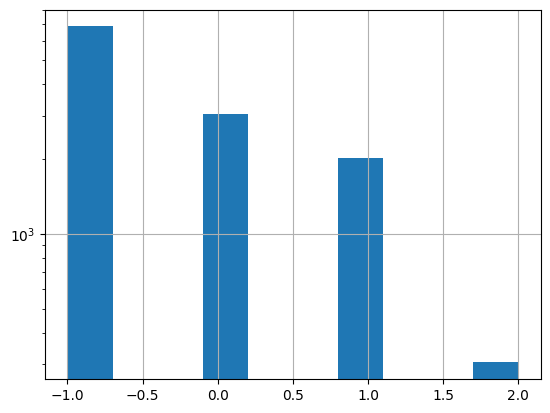

In [47]:
for conf in np.array(db_config[['eps', 'min_samples']]):
    eps = np.round(conf[0],3)
    min_samples = int(conf[1])
    print(eps, min_samples)

    # Configuring the parameters of the clustering algorithm
    dbscan_cluster = DBSCAN(eps=eps, 
                            min_samples=min_samples, 
                            metric="precomputed",
                            n_jobs=-1)

    # Fitting the clustering algorithm
    dbscan_cluster.fit(distance_matrix)

    plt.hist(dbscan_cluster.labels_) 
    plt.yscale('log')
    plt.grid()
    plt.show()

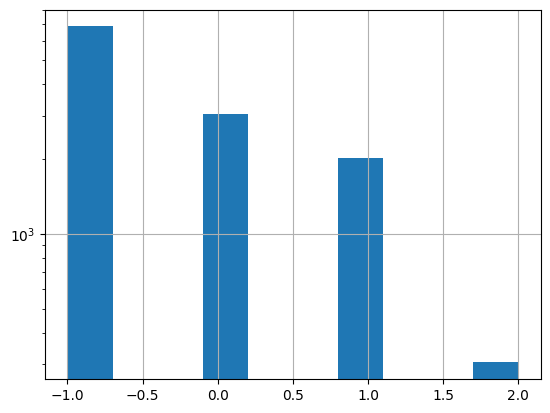

In [48]:
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.075, 
                        min_samples=40, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
plt.yscale('log')
plt.grid()
plt.show()

In [49]:
# Adding the results to a new column in the dataframe
X_train["cluster"] = dbscan_cluster.labels_
X_train.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income,cluster
26763,63.0,124242.0,9.0,0.0,0.0,40.0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,Black,Male,United-States,<=50K,0
32676,26.0,206721.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Rare,Unmarried,White,Male,United-States,<=50K,1
27426,18.0,348588.0,8.0,0.0,0.0,25.0,Private,Rare,Never-married,Exec-managerial,Own-child,Black,Male,United-States,<=50K,-1
29074,26.0,68991.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Other-service,Unmarried,Black,Male,United-States,<=50K,-1
30398,61.0,103575.0,9.0,0.0,0.0,37.0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K,0


In [101]:
# Relabel Clusters starting from 0
X_train["cluster"] = X_train["cluster"] + 1

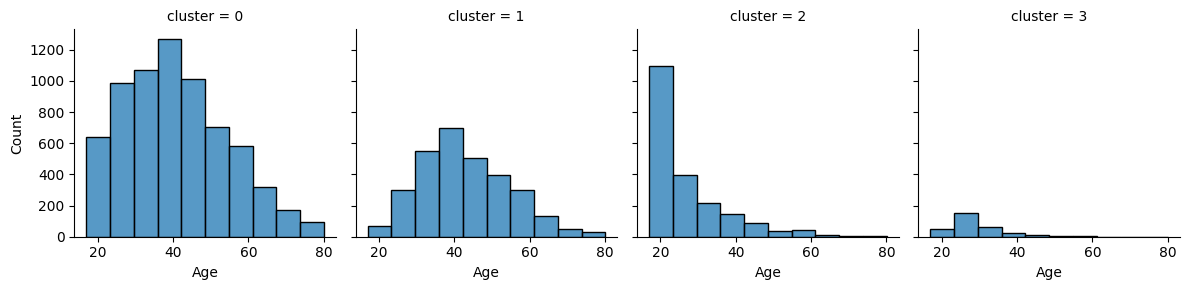

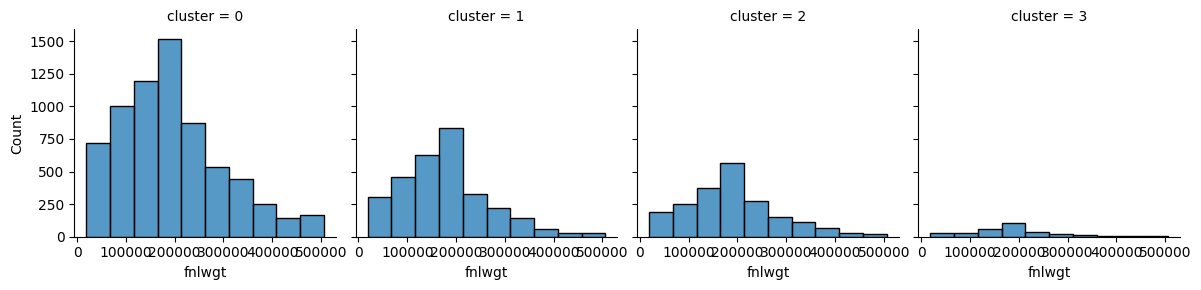

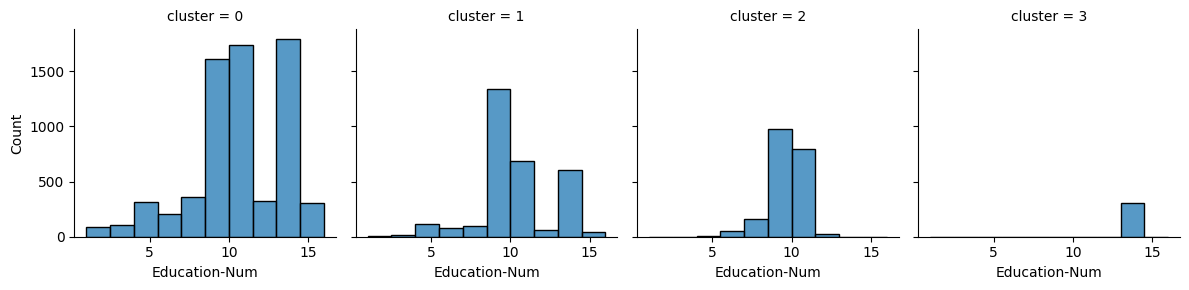

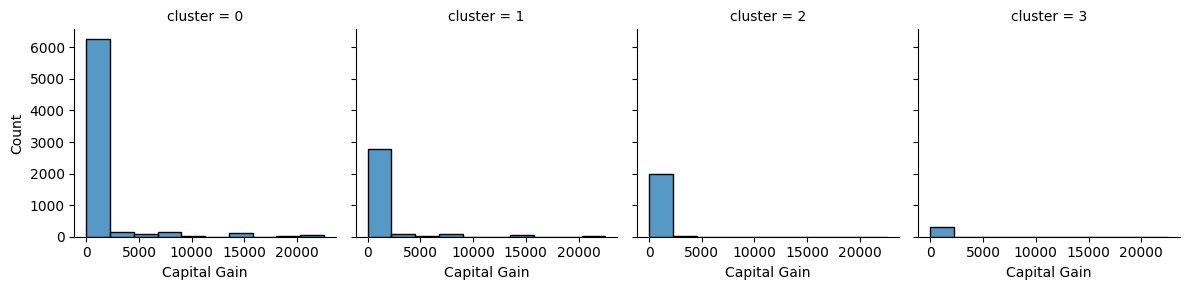

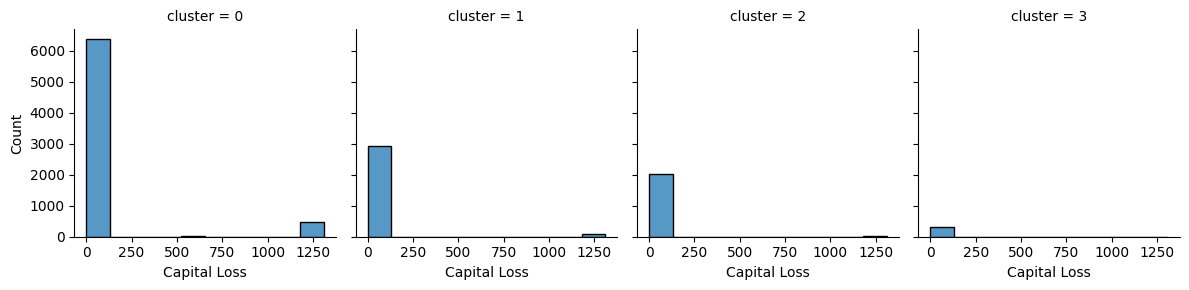

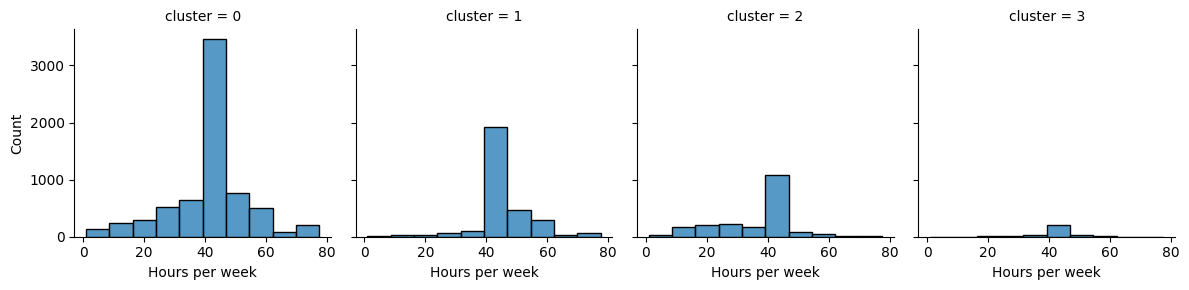

In [102]:
# Plot the histogram of various clusters
for feat in numeric_columns:
    sns.displot(
    X_train, 
    x=feat, 
    col="cluster",
    bins=10, 
    height=3, 
    facet_kws=dict(margin_titles=True)
    )
plt.show()

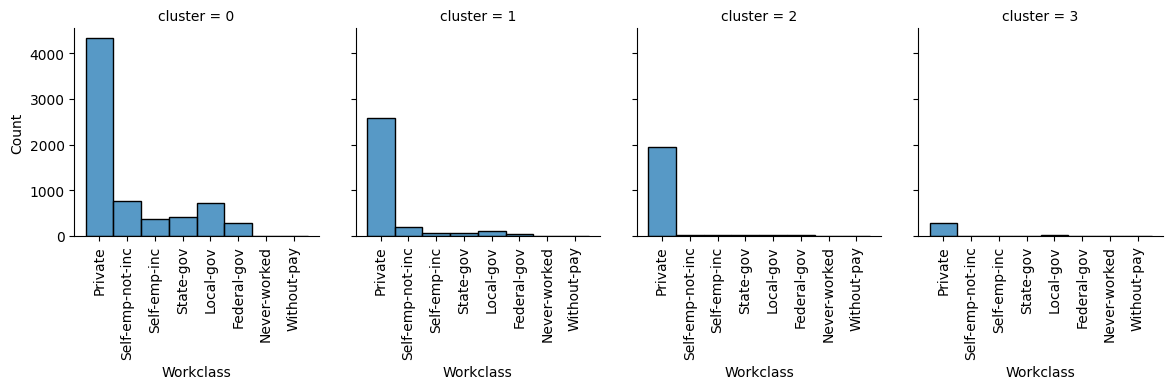

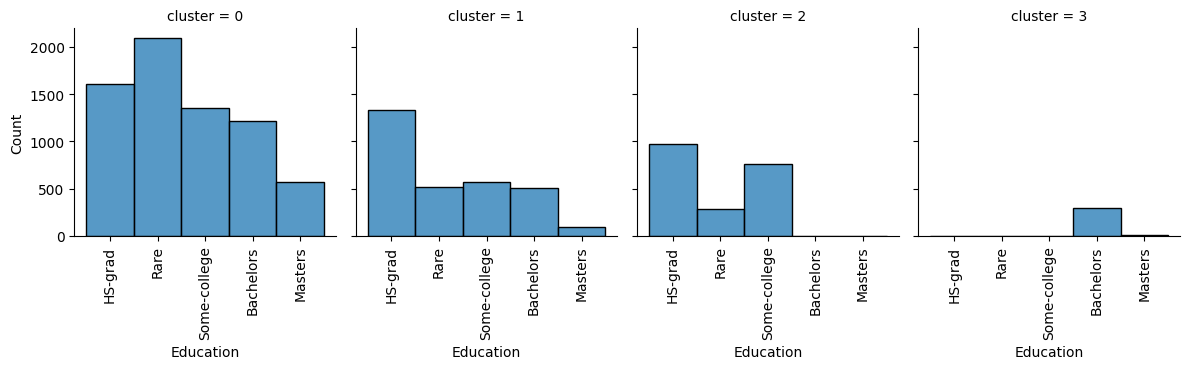

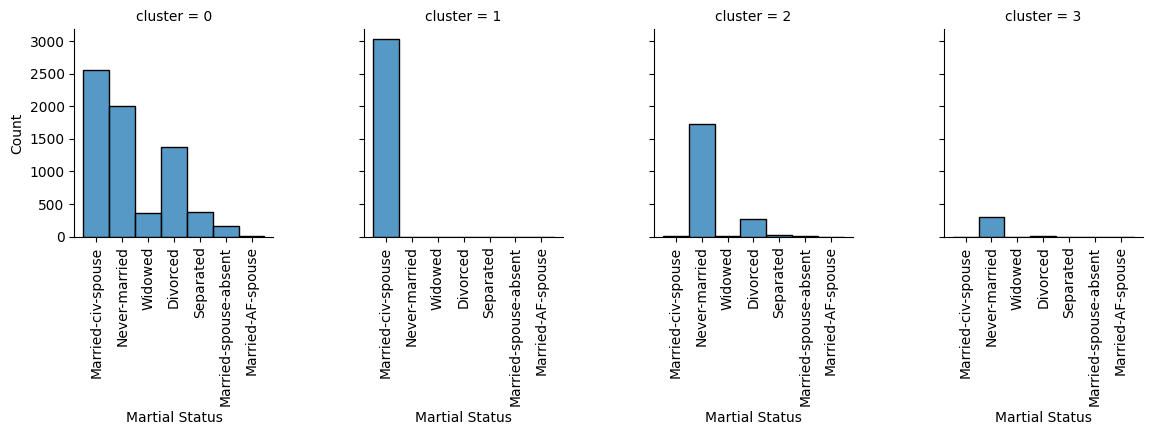

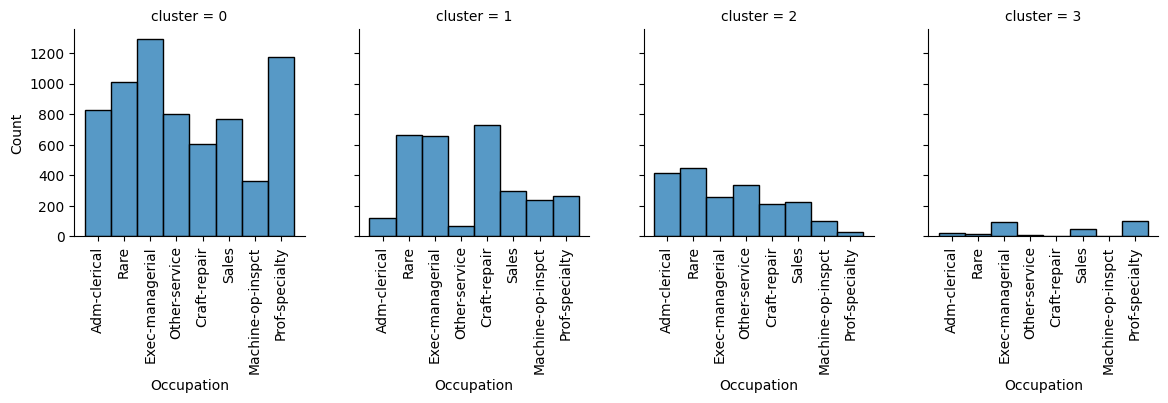

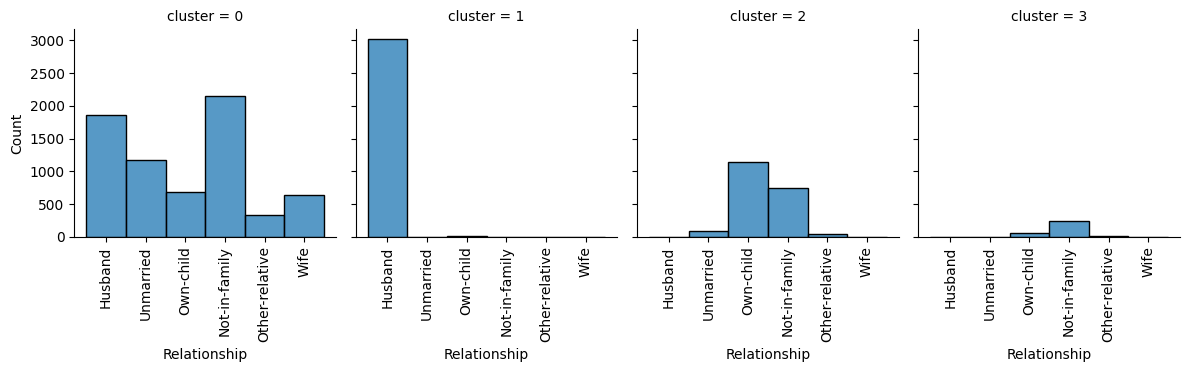

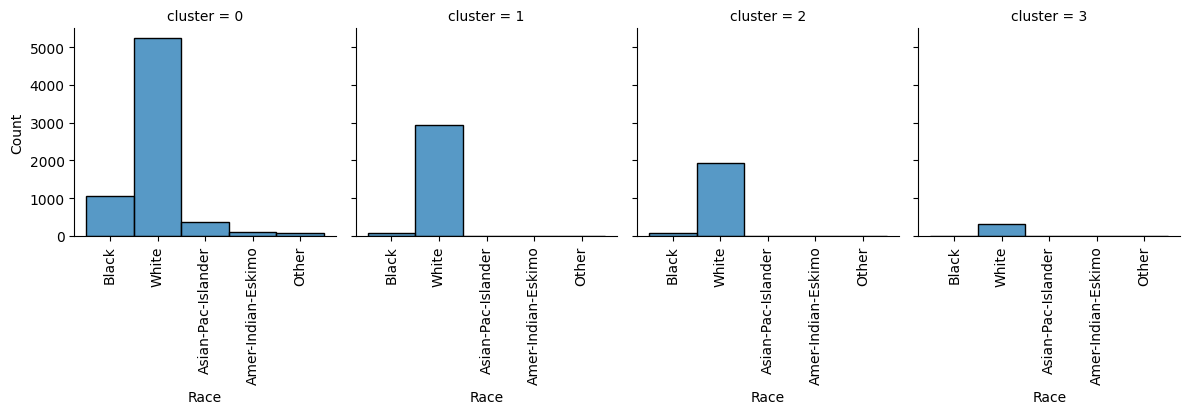

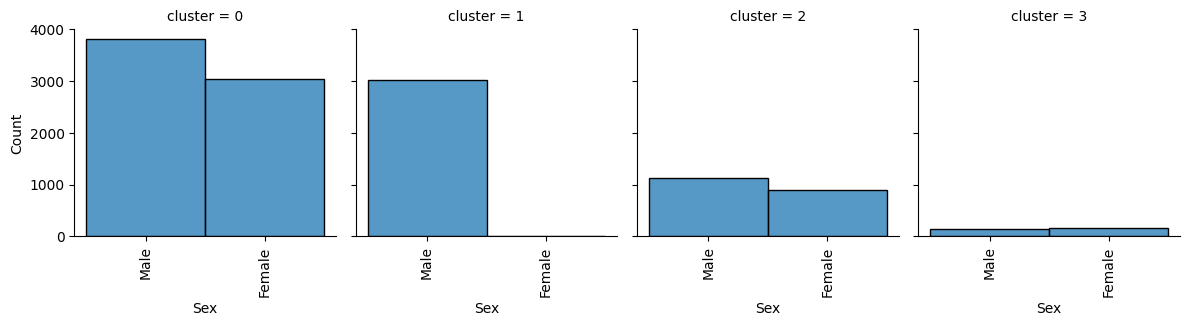

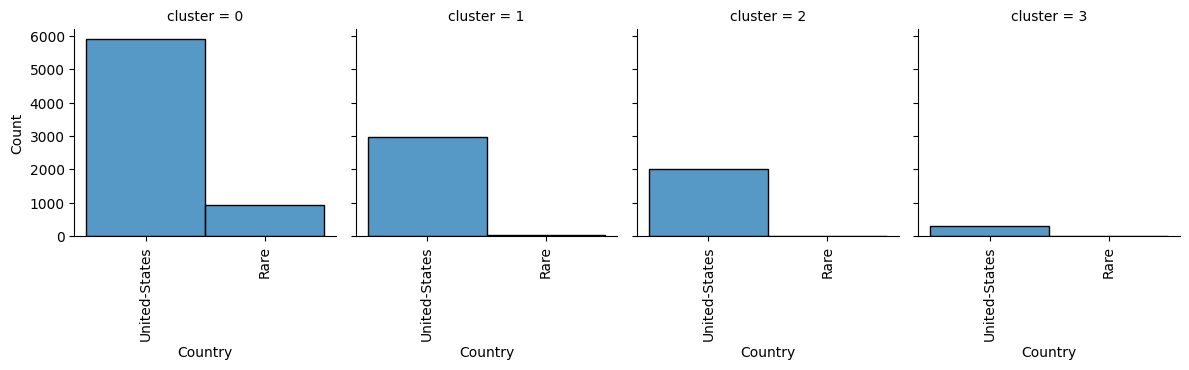

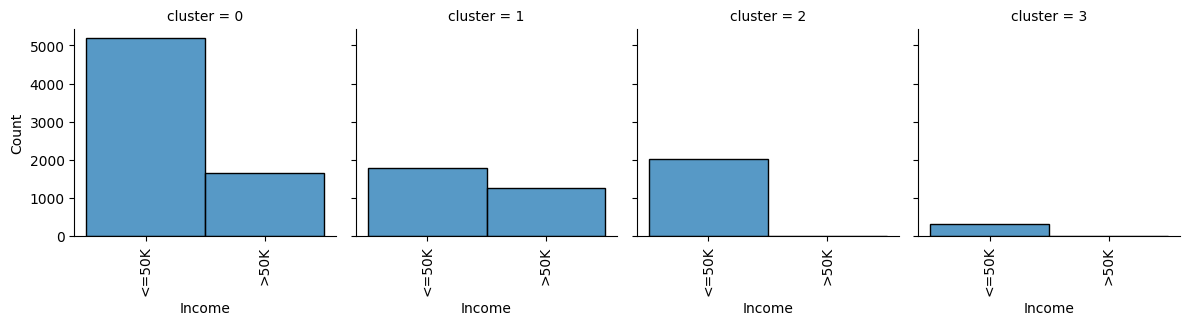

In [103]:
# Plot the histogram of various clusters
for feat in categorical_columns:
    fig = sns.displot(
    X_train, 
    x=feat, 
    col="cluster",
    kind='hist',
    height=3,
    facet_kws=dict(margin_titles=True)
    )
    fig.set_xticklabels(rotation=90)
plt.show()

# Train Model on Cluster Label

### One Hote Encode

In [104]:
from sklearn.preprocessing import OneHotEncoder

In [53]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first')

In [54]:
enc.fit(X_train[categorical_columns])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [55]:
X_train_hot_enc = enc.transform(X_train[categorical_columns])

In [56]:
# Save one hot encoder
from joblib import dump
dump(enc, '../artifacts/enc.joblib')

['../artifacts/enc.joblib']

In [57]:
X_train_cat_hotenc = pd.DataFrame(X_train_hot_enc, columns=enc.get_feature_names_out()) 
X_train_cat_hotenc.index = X_train.index 
X_train_cat_hotenc.head()

,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Education_HS-grad,Education_Masters,Education_Rare,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Male,Country_United-States,Income_>50K
26763,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
32676,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
27426,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
29074,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
30398,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [58]:
X_train_hotenc = pd.concat([X_train[numeric_columns], X_train_cat_hotenc], axis=1) 
X_train_hotenc

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,Workclass_Self-emp-inc,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Male,Country_United-States,Income_>50K
26763,63.0,124242.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
32676,26.0,206721.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
27426,18.0,348588.0,8.0,0.0,0.0,25.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
29074,26.0,68991.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
30398,61.0,103575.0,9.0,0.0,0.0,37.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,53.0,64322.0,4.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
15377,39.0,147548.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
17730,33.0,108116.0,9.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
28030,19.0,36012.0,9.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [105]:
y = X_train['cluster']

In [106]:
# create a train/test split
X_train_hotenc_train, X_train_hotenc_test, y_train, y_test = train_test_split(
    X_train_hotenc, 
    y, 
    test_size=0.3, 
    random_state=123)

# Training XGBoost

In [107]:
import xgboost

In [129]:
# train xgboost
clf = xgboost.XGBClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.3,
    n_jobs =-1)

clf.fit(X_train_hotenc_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [130]:
# evaluate accuracy on training set
clf.score(X_train_hotenc_train, y_train)

0.9586989586989587

In [131]:
# evaluate accuracy on test set
clf.score(X_train_hotenc_test, y_test)

0.9137319137319138

In [128]:
pred = clf.predict(X_train_hotenc_train)
pred

array([1, 0, 0, ..., 2, 1, 0], dtype=int64)

### Tuning XGBoost

In [139]:
parameters = {
    'n_estimators': (50, 100, 200, 300),
    'max_depth': (3, 5, 10),
    'learning_rate': (0.15, 0.3, 0.6)
    }

model = GridSearchCV(
    clf, 
    parameters,
    cv=3, 
    n_jobs =-1)

In [140]:
model.fit(X_train_hotenc_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.3, max_bin=256,
                                     max_cat_threshold=64, max_cat_to_onehot=4,
                                     max_delta_step=0, max_depth=5,
                                     max_leaves=0, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=50, n_jobs=-1,
                                     num_parallel_tree=1,
                                     objective='multi:softprob',
                                     predictor='auto', ...),
             n_jobs=-1,
             param_grid={'learning_rate': (0.15, 0.3, 0.6),
                         'max_depth': (3, 5, 10),
                         'n_estimators': (50, 100, 200, 300)})

In [145]:
# evaluate accuracy on training set
model.score(X_train_hotenc_train, y_train)

0.9942669942669943

In [146]:
# evaluate accuracy on test set
model.score(X_train_hotenc_test, y_test)

0.9265629265629266

In [147]:
# predict
model.predict(X_train_hotenc_train)

array([1, 2, 0, ..., 2, 1, 0], dtype=int64)

In [148]:
model.best_params_

{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 300}

In [149]:
# Save the trained classifier
from joblib import dump
dump(model, '../artifacts/model.joblib')

['../artifacts/model.joblib']

# Model Evaluation

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

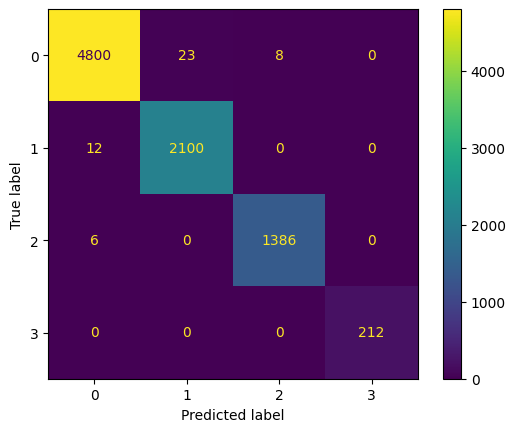

In [151]:
# plot confusion matrix for training data
cm = confusion_matrix(y_train, model.predict(X_train_hotenc_train), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()

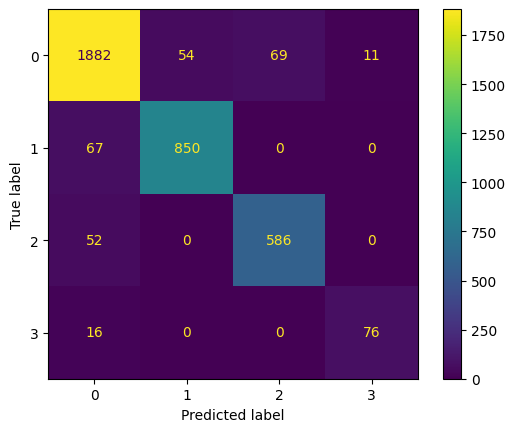

In [152]:
# plot confusion matrix for training data
cm = confusion_matrix(y_test, model.predict(X_train_hotenc_test), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()

# Explain Clusters

In [153]:
import shap

In [154]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model = model.best_estimator_, output = 'probability')
shap_values = explainer.shap_values(X_train_hotenc_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


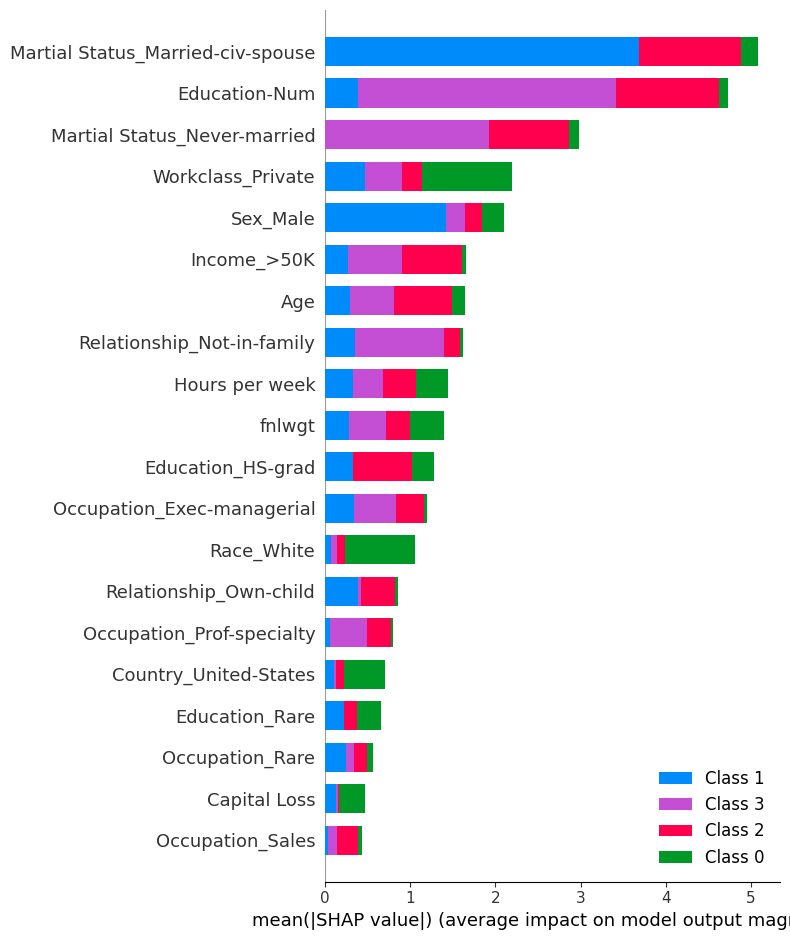

In [155]:
shap.summary_plot(shap_values, X_train_hotenc_train)

## Explain one distinct class

In [157]:
shap_values[1]

array([[-7.3248148e-01,  2.3763344e-02,  4.3469095e-01, ...,
         1.5394782e-01,  8.2482003e-02, -9.8210253e-02],
       [-2.7621689e-01,  1.9412242e-01,  2.5871581e-01, ...,
        -3.8039675e+00,  3.3493843e-02, -4.9301162e-03],
       [-1.7428984e-01,  2.2161856e-01,  3.2370394e-01, ...,
        -3.8427048e+00, -2.8352618e-01,  5.1966421e-02],
       ...,
       [-1.9292042e-02, -9.4247572e-02,  7.3635355e-02, ...,
         7.3206991e-02,  3.0654136e-02,  2.6848882e-01],
       [-1.5652075e-01,  4.0213168e-01,  3.5628110e-01, ...,
         2.1311697e-01,  8.2777455e-02, -1.4858552e-02],
       [ 4.4132590e-01,  1.5112427e-01,  1.5098903e-01, ...,
        -3.9764137e+00,  2.9310586e-02,  3.3114743e-03]], dtype=float32)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


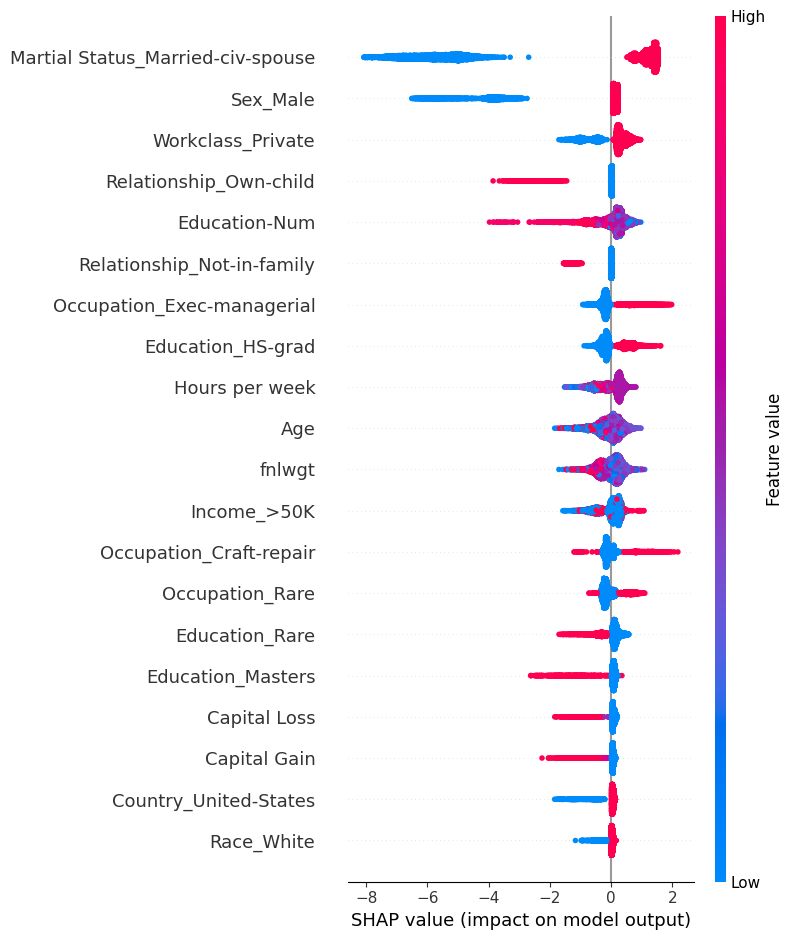

In [158]:
shap.summary_plot(shap_values[1], X_train_hotenc_train)

### Explain single prediction

In [159]:
explainer.expected_value

[1.7895603, 0.8705152, -0.21426678, -2.3803098]

In [160]:
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train_hotenc_train.iloc[0,:])